# pvanalysis

The `pvanalysis` package of `SLAM` is a tool to identify Keplerian disks in protostellar systems using position-velocity (PV) diagrams and estimate the dynamical mass of protostars if disks are present. This tool basically consists of two steps: `get_edgeridge`, which determines edge/ridge points that trace rotation curve features of PV diagrams, and `fit_edgeridge`, which performs the power-law fitting with the obtained edge/ridge points. In this note, we will briefly present how to use this tool.

In [1]:
import numpy as np
# if you need to set a path
import sys
sys.path.append('D:\L1489_IRS_ssp\SLAM') # add PATH to SLAM

from pvanalysis import PVAnalysis
import matplotlib.pyplot as plt

In [2]:
#%matplotlib widget

## Basic usage B6

Here is an example only with the most basic input parameters to deomnstrate the simplest usage. The first step of `pvanalysis` is to extract edge/ridge points from a PV diagram.

In [4]:
# -------- INPUTS --------
fitsfile = 'testfits/uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_54_w1.fits'
outname = 'pvanalysis_b6_gridge'  # file name header for outputs
incl = 73.  # inclunation angle (deg)
vsys = 7.2  # systemic velocity (km/s)
dist = 140.  # distance to the object (pc)
rms = 6.92e-3  # rms noise level (Jy/beam)
thr = 5.  # threshold for noise cut-off for edge/ridge calculations (rms)
# -------------------------


# read PV diagram
# give rms, vsys, distance, and inclination angle
impv = PVAnalysis(fitsfile, rms, vsys, dist, incl=incl, pa=69.)
# get edge/ridge points
impv.get_edgeridge(outname, thr=thr, xlim=[-1000.,0,0,1000.], ridgemode='gauss', pixrng_vcut=3)
impv.write_edgeridge(outname=outname)

read_pvfits: Input P.A.: 69.0 deg
read_pvfits: Convert frequency to velocity
Along position axis.
x range: -9.00 -- 9.00 arcsec
v range: -0.96 -- 13.42 km/s
Along velocity axis.
x range: -9.00 -- 9.00 arcsec
v range: -0.96 -- 13.42 km/s
Derived points in pvanalysis_b6_gridge.edge.dat and pvanalysis_b6_gridge.ridge.dat.


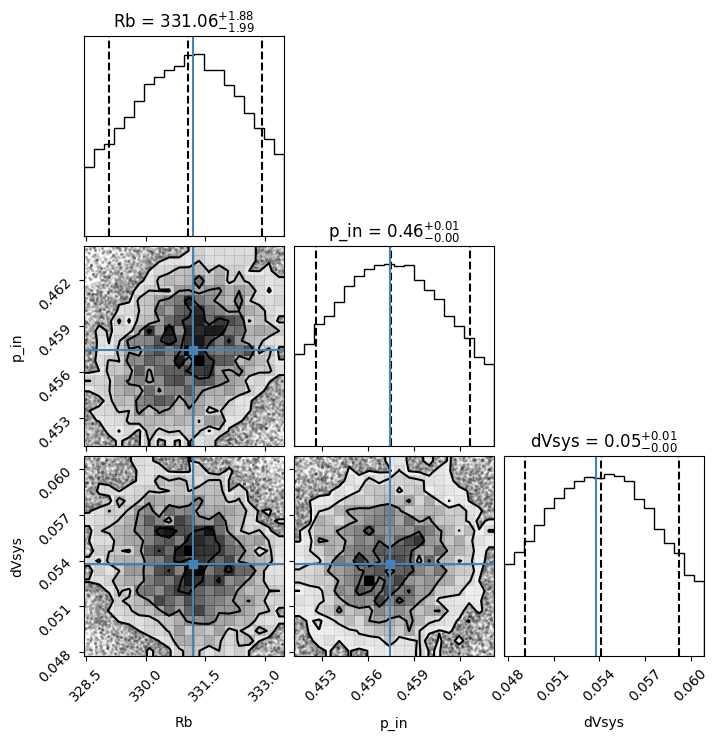

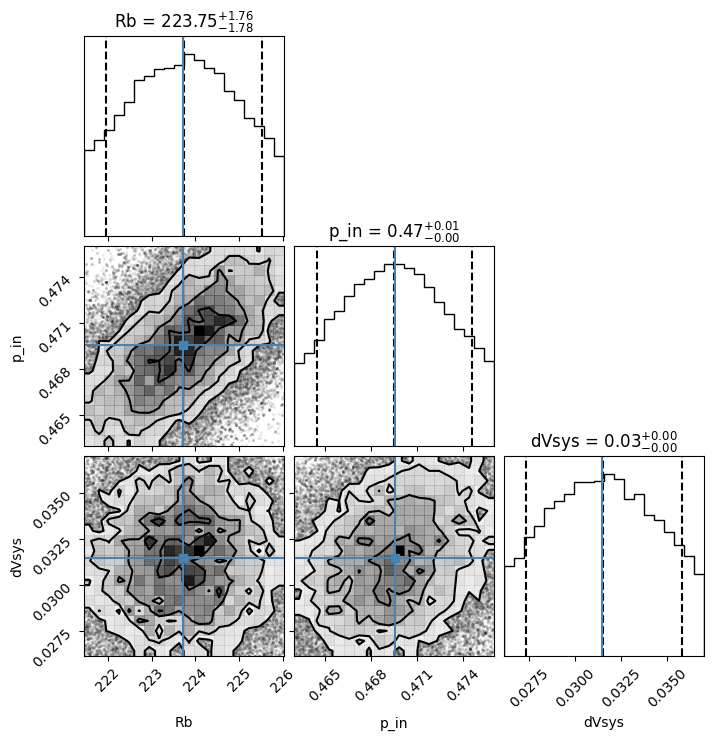

Corner plots in pvanalysis_b6_gridge.corner_e.png and pvanalysis_b6_gridge.corner_r.png
--- Edge ---
R_b   = 331.06 +/- 1.94 au
!!! Rb is NOT a break (disk) radius in the single-power fitting. !!!
V_b   = 2.256 +/- 0.000 km/s
!!! Vb is a middle velocity in the single-power fitting. !!!
p_in  = 0.458 +/- 0.005
dp    = 0.000 +/- 0.000
v_sys = 7.254 +/- 0.005
r     = 66.47 --- 1008.00 au
v     = 1.410 --- 4.758 km/s
M_in  = 1.813 +/- 0.034 Msun
M_out = 2.284 +/- 0.032 Msun
M_b   = 2.078 +/- 0.012 Msun
--- Ridge ---
R_b   = 223.75 +/- 1.77 au
!!! Rb is NOT a break (disk) radius in the single-power fitting. !!!
V_b   = 2.050 +/- 0.000 km/s
!!! Vb is a middle velocity in the single-power fitting. !!!
p_in  = 0.470 +/- 0.005
dp    = 0.000 +/- 0.000
v_sys = 7.232 +/- 0.004
r     = 37.78 --- 1008.00 au
v     = 1.043 --- 4.758 km/s
M_in  = 1.040 +/- 0.022 Msun
M_out = 1.271 +/- 0.023 Msun
M_b   = 1.159 +/- 0.009 Msun


In [5]:
# power law fitting
# --------- input parameters ----------
include_vsys = True  # vsys offset. False means vsys=0.
include_dp = False  # False means a single power
include_pin = True # False means pin=0.5 (Keplerian).
fixed_pin = 0.5  # Set the fixed pin value when include_pin is False.
fixed_dp = 0.0  # Set the fixed dp value when include_dp is False.
show_corner = True # if show corner plots or not
# -------------------------------------
impv.fit_edgeridge(include_vsys=include_vsys,
                   include_dp=include_dp,
                   include_pin=include_pin,
                   fixed_pin=fixed_pin, fixed_dp=fixed_dp,
                   outname=outname, rangelevel=0.8,
                   show_corner=show_corner)
impv.output_fitresult()


In [6]:
# For ridge

V_sys, V_sys_err = 7.232, 0.004
V_b, V_b_err = 2.05, 0.000
R_b, R_b_err = 223.75 , 1.77
p = 0.475 
perr = 0.005


# Find scaling constant V100 (V at r = 100) using Vb, Rb... equate V_b(r/Rb)**-0.5 with V_100(r/100)**-0.5 
V_100 = V_b*np.power(R_b/100, p)


 # Calculate the partial derivatives
dv_dvb = (100 / R_b)**p
dv_drb = -V_b * p * (100 / R_b)**p * (1 / R_b)
dv_dp = V_b * (100 / R_b)**p * np.log(100 / R_b)

# Calculate the propagated error using the partial derivatives
sigma_v = np.sqrt((dv_dvb * V_b_err)**2 + (dv_drb * R_b_err)**2 + (dv_dp * perr)**2)



print(round(V_100,3))
print(round(sigma_v,3))

3.005
0.008


The input parameters set free parameters and which model function (single or double power-law) is adopted. In the above case, the fitting model is a double-power law function with a fixed inner power-law index ($p_\mathrm{in}=0.5$). The fitting searches the best break point ($R_\mathrm{b}$, $V_\mathrm{b}$), where the power-law index changes, and $dp$, which is deviation of the outer power-law index from the innder one. The dynamical mass ($M_\mathrm{b}$) is estimated from the set of ($R_\mathrm{b}$, $V_\mathrm{b}$) and a given inclination angle assuming a Keplerian rotation.

The edge/ridge points and the best-fit functions can be visualized as follows.

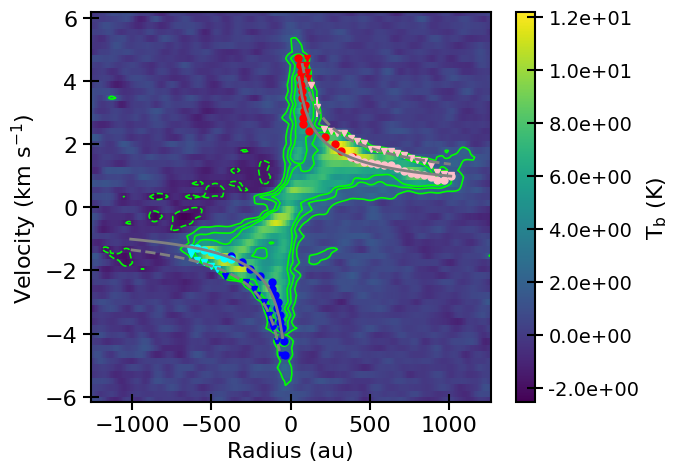

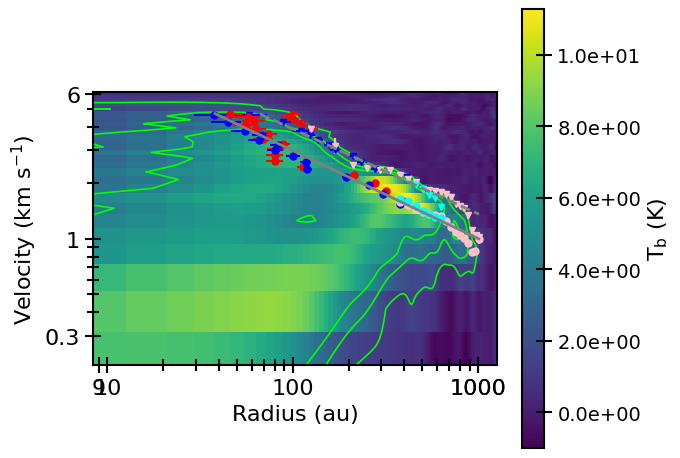

In [10]:
# plot results
impv.plot_fitresult(outname=outname, clevels=[-3,3,6,9],
                    vlim=[1.e-10,15.],
                    Tbcolor=True,
                    kwargs_pcolormesh={'cmap':'viridis'},
                    kwargs_contour={'colors':'lime'},
                    fmt={'edge':'v', 'ridge':'o'},
                    linestyle={'edge':'--', 'ridge':'-'})

## B7


In [7]:
# -------- INPUTS --------
fitsfile = 'D:/L1489_IRS_ssp/SLAM/testfits/uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_54_w1.fits'
outname = 'pvanalysis_b7_gridge'  # file name header for outputs
incl = 73.  # inclunation angle (deg)
vsys = 7.2  # systemic velocity (km/s)
dist = 140.  # distance to the object (pc)
rms = 3.45e-02  # rms noise level (Jy/beam)
thr = 5.  # threshold for noise cut-off for edge/ridge calculations (rms)
# -------------------------


# read PV diagram
# give rms, vsys, distance, and inclination angle
impv = PVAnalysis(fitsfile, rms, vsys, dist, incl=incl, pa=69.)
# get edge/ridge points
impv.get_edgeridge(outname, thr=thr, xlim=[-1000.,0,0,1000.], ridgemode='gauss', pixrng_vcut=3)
impv.write_edgeridge(outname=outname)

read_pvfits: Input P.A.: 69.0 deg
read_pvfits: Convert frequency to velocity
Along position axis.
x range: -9.00 -- 9.00 arcsec
v range: -0.96 -- 13.42 km/s
Along velocity axis.
x range: -9.00 -- 9.00 arcsec
v range: -0.96 -- 13.42 km/s
Derived points in pvanalysis_b7_gridge.edge.dat and pvanalysis_b7_gridge.ridge.dat.


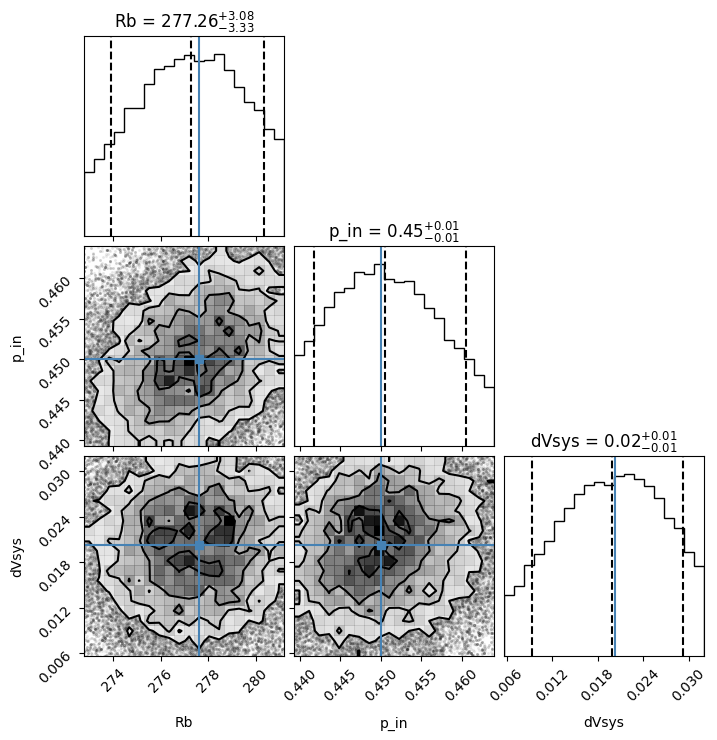

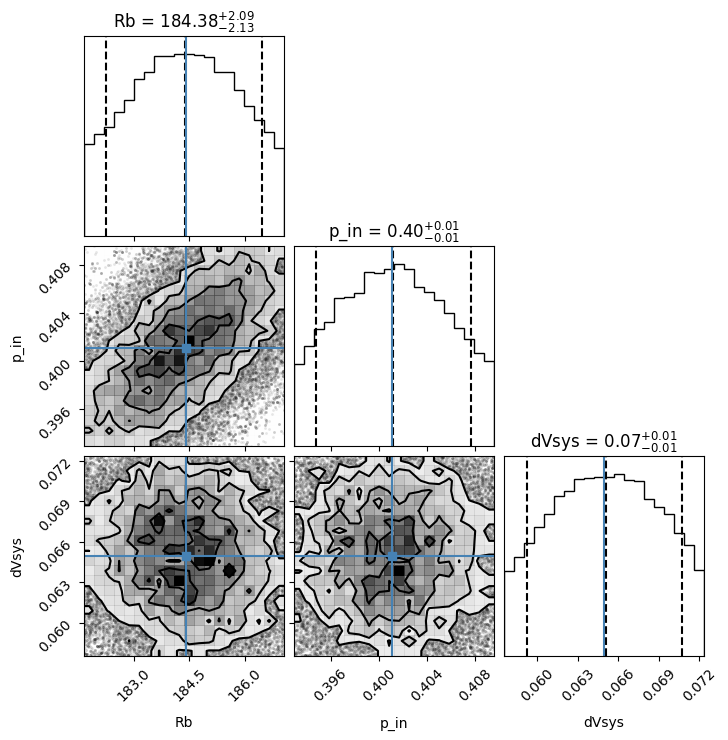

Corner plots in pvanalysis_b7_gridge.corner_e.png and pvanalysis_b7_gridge.corner_r.png
--- Edge ---
R_b   = 277.26 +/- 3.21 au
!!! Rb is NOT a break (disk) radius in the single-power fitting. !!!
V_b   = 2.337 +/- 0.000 km/s
!!! Vb is a middle velocity in the single-power fitting. !!!
p_in  = 0.451 +/- 0.009
dp    = 0.000 +/- 0.000
v_sys = 7.220 +/- 0.010
r     = 70.82 --- 798.00 au
v     = 1.471 --- 4.341 km/s
M_in  = 1.630 +/- 0.051 Msun
M_out = 2.071 +/- 0.054 Msun
M_b   = 1.866 +/- 0.022 Msun
--- Ridge ---
R_b   = 184.38 +/- 2.11 au
!!! Rb is NOT a break (disk) radius in the single-power fitting. !!!
V_b   = 2.212 +/- 0.000 km/s
!!! Vb is a middle velocity in the single-power fitting. !!!
p_in  = 0.401 +/- 0.006
dp    = 0.000 +/- 0.000
v_sys = 7.265 +/- 0.006
r     = 35.66 --- 798.00 au
v     = 1.294 --- 4.341 km/s
M_in  = 0.804 +/- 0.023 Msun
M_out = 1.486 +/- 0.032 Msun
M_b   = 1.112 +/- 0.013 Msun


In [8]:
# power law fitting
# --------- input parameters ----------
include_vsys = True  # vsys offset. False means vsys=0.
include_dp = False  # False means a single power
include_pin = True # False means pin=0.5 (Keplerian).
fixed_pin = 0.5  # Set the fixed pin value when include_pin is False.
fixed_dp = 0.0  # Set the fixed dp value when include_dp is False.
show_corner = True # if show corner plots or not
# -------------------------------------
impv.fit_edgeridge(include_vsys=include_vsys,
                   include_dp=include_dp,
                   include_pin=include_pin,
                   fixed_pin=fixed_pin, fixed_dp=fixed_dp,
                   outname=outname, rangelevel=0.8,
                   show_corner=show_corner)
impv.output_fitresult()


In [9]:
# For ridge

V_sys, V_sys_err = 7.265, 0.006
V_b, V_b_err = 2.212, 0.000
R_b, R_b_err = 184.38, 2.11 
p = 0.401
perr = 0.006

# Find scaling constant V100 (V at r = 100) using Vb, Rb... equate V_b(r/Rb)**-0.5 with V_100(r/100)**-0.5 
V_100 = V_b*np.power(R_b/100, p)

 # Calculate the partial derivatives
dv_dvb = (100 / R_b)**p
dv_drb = -V_b * p * (100 / R_b)**p * (1 / R_b)
dv_dp = V_b * (100 / R_b)**p * np.log(100 / R_b)

# Calculate the propagated error using the partial derivatives
sigma_v = np.sqrt((dv_dvb * V_b_err)**2 + (dv_drb * R_b_err)**2 + (dv_dp * perr)**2)

print(round(V_100,3))
print(round(sigma_v,3))

2.827
0.01


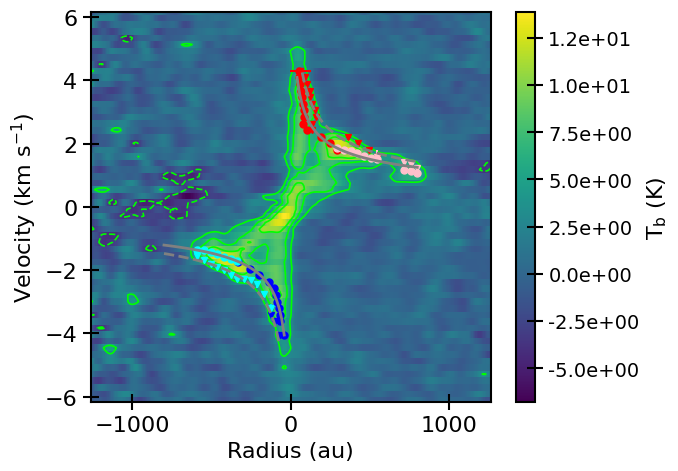

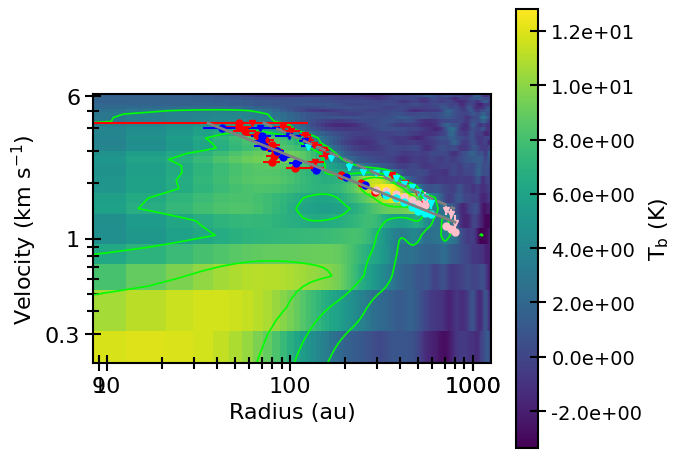

In [10]:
# plot results
impv.plot_fitresult(outname=outname, clevels=[-3,3,6,9],
                    vlim=[1.e-10,15.],
                    Tbcolor=True,
                    kwargs_pcolormesh={'cmap':'viridis'},
                    kwargs_contour={'colors':'lime'},
                    fmt={'edge':'v', 'ridge':'o'},
                    linestyle={'edge':'--', 'ridge':'-'},)

